# Plot three distributions

## generate 3 sets of data

In [18]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, random_clifford,Pauli,Operator,partial_trace,entropy
import numpy as np
from quantum_simulation_recipe.spin import Nearest_Neighbour_1d
from quantum_simulation_recipe.trotter import *
from quantum_simulation_recipe.bounds import norm, tight_bound, commutator
from quantum_simulation_recipe.plot_config import *
from qiskit.quantum_info import random_statevector

from functools import partial
from itertools import product
from tqdm import tqdm
from numpy.linalg import matrix_power

from quantum_simulation_recipe.spin import Nearest_Neighbour_1d
from quantum_simulation_recipe.trotter import pf, expH
from qiskit.quantum_info import SparsePauliOp, random_statevector, Statevector, Pauli, partial_trace, entropy
import matplotlib.pyplot as plt
from quantum_simulation_recipe.plot_config import *
set_fontsize(linewidth=2)
fig_dir, data_dir = './figs', './data'
# rand_sv = random_statevector(2**10)
# rand_sv
# print('by jax', state_magic_jax(rand_sv))
# print('by numpy loop', state_linear_magic(rand_sv))
def local_random_clifford(n):
    a = random_clifford(1)
    i = 1
    while i < n:
        a = a.expand(random_clifford(1))
        i += 1
    return a

In [19]:
n = 10 # 10
t = 10  
r = 100 # 100

dt = t/r
# H_model = 'MFI'
# hx, hy, Jx = 1, 0.9, 0.8
Jx, hx, hy = 1, 0.8090, 0.9045
print(f't={t}, r={r}, dt={dt}')

# # init_state_str = '0'*n
# init_state_str = '10'*(n//2)
# init_state = Statevector.from_label(init_state_str).data

## QMFI
qmfi = Nearest_Neighbour_1d(n, hx=hx, hy=hy, Jx=Jx, pbc=False)
qmfi_xx_even = SparsePauliOp.from_sparse_list([*qmfi.xx_tuples[::2]], num_qubits=n).simplify()
qmfi_xx_odd = SparsePauliOp.from_sparse_list([*qmfi.xx_tuples[1::2]], num_qubits=n).simplify()
qmfi_x_terms = SparsePauliOp.from_sparse_list([*qmfi.x_tuples], num_qubits=n).simplify()
qmfi_y_terms = qmfi.y_terms
qmfi_H_list = [qmfi_x_terms, qmfi_y_terms, qmfi_xx_even, qmfi_xx_odd] 
qmfi_H_ordered = sum(qmfi_H_list)
qmfi_U_dt_ideal = expH(sum(qmfi_H_ordered), dt, use_jax=True) 
print('qmfi_U_dt_ideal finished')
qmfi_U_dt_appro = pf(qmfi.ham_par, dt, 1, 1, use_jax=True)
print('qmfi_U_dt_appro finished')


antystates=np.load("./mag_time_data/AtyStates.npy")
tystates=np.load("./mag_time_data/TyStates.npy")

st_lowmag_lowent=Statevector(tystates[1])
st_highmag_lowent=Statevector(antystates[4])
st_highmag_highent=Statevector(tystates[39])
for j,st in enumerate([st_lowmag_lowent,st_highmag_lowent,st_highmag_highent]):
    current_state_ideal, current_state_appro = st.data, st.data
    current_state_ideal = qmfi_U_dt_ideal @ current_state_appro
    current_state_appro = qmfi_U_dt_appro @ current_state_appro
    error = np.linalg.norm(current_state_ideal - current_state_appro)
    print("error:",error)

t=10, r=100, dt=0.1
qmfi_U_dt_ideal finished
qmfi_U_dt_appro finished
error: 0.025380796
error: 0.0274354
error: 0.025557071


In [27]:
from time import sleep
from tqdm import tqdm
error0=np.load("./newdata/lowmag_lowent_error.npy").tolist()
error1=np.load("./newdata/highmag_lowent_error.npy").tolist()
error2=np.load("./newdata/highmag_highent_error.npy").tolist()
#distribution of local magic and entanglement
count=100000
for i in tqdm(range(count)):
    if i % 100 == 0:
        np.save("./newdata/lowmag_lowent_error.npy",error0)
        np.save("./newdata/highmag_lowent_error.npy",error1)
        np.save("./newdata/highmag_highent_error.npy",error2)
    for j,st in enumerate([st_lowmag_lowent,st_highmag_lowent,st_highmag_highent]):
        st=st.evolve(local_random_clifford(n))
        current_state_ideal, current_state_appro = st.data, st.data
        current_state_ideal = qmfi_U_dt_ideal @ current_state_appro
        current_state_appro = qmfi_U_dt_appro @ current_state_appro
        error = np.linalg.norm(current_state_ideal - current_state_appro)
        if j==0:
            error0.append(error)
        elif j==1:
            error1.append(error)
        else:
            error2.append(error)
np.save("./newdata/lowmag_lowent_error.npy",error0)
np.save("./newdata/highmag_lowent_error.npy",error1)
np.save("./newdata/highmag_highent_error.npy",error2)
print("Data saved.")


 20%|█▉        | 19703/100000 [28:31:18<116:14:11,  5.21s/it]  


KeyboardInterrupt: 

74555 74555 74555


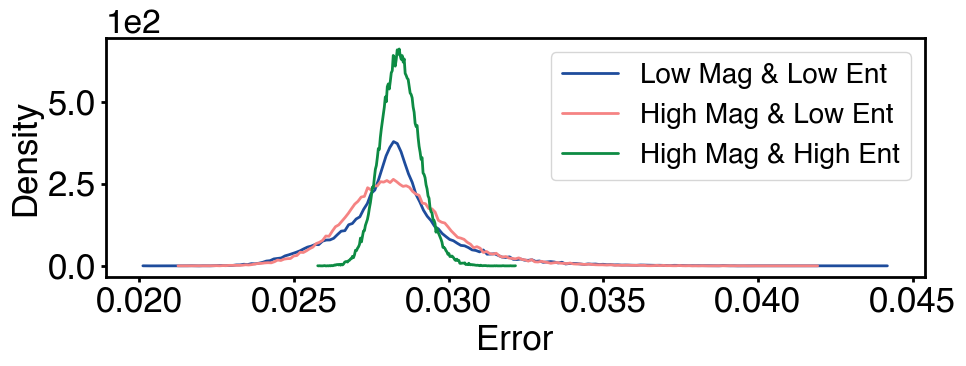

In [50]:
# # Plot three distributions
import matplotlib.pyplot as plt
lowmag_lowent_error=np.load("./newdata/lowmag_lowent_error.npy").tolist()
highmag_lowent_error=np.load("./newdata/highmag_lowent_error.npy").tolist()
highmag_highent_error=np.load("./newdata/highmag_highent_error.npy").tolist()
del lowmag_lowent_error[74554:-1]
del highmag_lowent_error[74554:-1]
del highmag_highent_error[74554:-1]
print(len(lowmag_lowent_error),len(highmag_lowent_error),len(highmag_highent_error))
fig, ax=plt.subplots(figsize=(10,4))
ls = 25
les = 20
fontprops = {'size': 38}
labels=['Low Mag & Low Ent','High Mag & Low Ent','High Mag & High Ent']
colors = ['#1E4C9C', '#F58383', '#0D8B43', '#ECAC27', '#7B92C7', '#FB8C62', '#B0DC66', '#8C9FCA', '#C9C780', '#66C1A4', '#FCB2AF', '#9BDFDF', '#FFE2CE', '#C4D8E9', '#BEBCDF', '#4C9BE6', '#B2B6C1', '#4C7780', '#73A5A2', '#F6E2C1', '#F3DBC1', '#D6E2E2', '#F0EFED', '#E3BBED', '#26445E']
for j,error in enumerate([lowmag_lowent_error,highmag_lowent_error,highmag_highent_error]):
    hists, bins = np.histogram(error, 200,density=True)
    ax.plot(bins[:-1], np.power(hists, 1), linewidth=2, color=colors[j],label=labels[j])
ax.set_xlabel("Error",fontsize=ls)
ax.set_ylabel("Density",fontsize=ls)
ax.tick_params(axis='both', which='major', labelsize=ls)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.legend(loc='best',fontsize=les)
plt.savefig('3distibutions.pdf', bbox_inches='tight', pad_inches=0.1,dpi=200,transparent=True)